# Extracting data from PVlib and PVGis

### Installing the Package PVLib

Jupyter Notebook

In [ ]:
# conda install -c pvlib pvlib 

Google Colab

In [ ]:
# pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 49.7 MB/s eta 0:00:00


In [ ]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# The next line is to make the plots appear in the notebook
%matplotlib inline 

In [ ]:
def obtain_panel_power_data(lat, lon, start, end, name, tilt, azimuth, panels, peakpower):
    """
    Determine the solar radiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param start: Startdate for data retrievel
    :param end: Endddate for data retrievel
    :param name: Name of the panel location on the object
    :param tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
    :param azimuth: Direction the panels, 0 is South, negative from south to east, positive from south to west
    :param panels: Number of panels on the location
    :param peakpower: Peakpower per panel
    :return:
    """
    if panels > 0:
        poa, _, _ = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=True, peakpower=peakpower*panels,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
    else:
        poa, _, _ = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=False,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
        poa['P'] = 0.0
    poa['date'] = pd.to_datetime(poa.index.date)
    poa['location'] = name
    poa['P'] = poa['P'].div(1000)    # change unit to kWh
    return poa

In [ ]:
def get_data_for_location(lat, lon, panels,
                          startdate = pd.Timestamp('2005-01-01'), enddate = pd.Timestamp('2020-12-31')):
    """
    Determine the solar radiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param panels: panel locations
    :return: 
    """
    poas = {}
    poalist = []
    for panel in panels:
        poa = obtain_panel_power_data(lat, lon, startdate, enddate, 
                                      panel['name'], panel['tilt'], 
                                      panel['azimuth'], panel['nopanels'], panel['power'])
        poas[panel['name']] = poa
        poalist.append(poa)
                          
    dataset = pd.concat(poalist).sort_index()
    
    dataset = pd.merge(
        pvlib.solarposition.get_solarposition(dataset.index.unique(), lat, lon)[['zenith', 'elevation', 'azimuth']], 
        dataset,
        left_index=True, right_index=True).drop_duplicates()
    dataset = dataset.sort_values(['time', 'location'])
    dataset['month'] = dataset.index.month
    dataset['season'] = 1 + (dataset.month - 1) // 3
    return dataset

## Getting the Database

Configuration of the PV System

In [ ]:
### PANEL CONFIGURATION
names    = ['front', 'back']  # PV configuration in relation to the Sun, front facing it and back with it's back facing it
tilts    = [35     , 35    ]  # PV Modules tilt Angle - In this analysis was defined as 35º
azimuths = [0     , 180   ]   # pvlib uses 0=North, 90=East, 180=South, 270=West as a convention, 
                              # To maximize the output the surface azimuth for the North Hemisphere should be 180(South)
nopanels = [5      , 10    ]  # Number of panels 
power    = [0.385  , 0.385 ]  # Individual power of the panels in KWp

panel_conf = []
for n, t, a, no, p in zip(names, tilts, azimuths, nopanels, power):
    panel_conf.append({"name": n, "tilt": t, "azimuth": a, "nopanels": no, 'power': p})

Making some assumptions: </br>
The PV modules considered will be FIXED and installed in roofs with 35º of TILT ANGLE. The Optimal tilt angle for Germany is 35-40º </br>
The analysis is for modules installed in the NORTH hemisphere. </br>
The azimuth considered will be 180º facing the TRUE SOUTH (back) and TRUE NORTH (front). </br>
The number of PV modules(panels) considered will be 5 for FRONT and 10 for BACK. </br>
The PV nominal power considered will be 385 Wp </br> 


In [ ]:
#Obtaining the data for Berlin
lat = 52.5
lon = 13.4
df = get_data_for_location(lat, lon, panel_conf) # calling the function and obtaining the data for the given location.

# Exploring the dataset

In [ ]:
df.head(5)

,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,date,location,month,season
time,,,,,,,,,,,,,,,
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.79,3.66,0,2005-01-01,back,1,1
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.79,3.66,0,2005-01-01,front,1,1
2005-01-01 01:11:00+00:00,142.557186,-52.557186,49.775589,0.0,0.0,0.0,0.0,0.0,6.72,3.52,0,2005-01-01,back,1,1
2005-01-01 01:11:00+00:00,142.557186,-52.557186,49.775589,0.0,0.0,0.0,0.0,0.0,6.72,3.52,0,2005-01-01,front,1,1
2005-01-01 02:11:00+00:00,134.776168,-44.776168,67.127870,0.0,0.0,0.0,0.0,0.0,6.74,3.31,0,2005-01-01,back,1,1


 A illustration describing the Solar angles.

<center>
<img src='https://hvac-eng.com/wp-content/uploads/2019/04/Orientation3.png'
style="position:absolute; top:15px; left:100px; z-index:10; width:80px; height:80px; border:none;" />
<font size = 4>
<figcaption> Solar Angles </figcaption> 
</font>
</center>
</figure>


<figure>
<center>
<img src='https://www.researchgate.net/publication/354755033/figure/fig2/AS:1070891857362948@1632331923300/Schematic-depicting-the-solar-zenith-angle-solar-altitude-angle-and-solar-azimuth-angle.ppm' />
<font size = 4>
<figcaption>Solar Angles Description</figcaption></center>
</font>
</figure>


In [ ]:
df.describe(include= "all").round(2)

<ipython-input-11-4abcafedd842>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include= "all").round(2)


,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,date,location,month,season
count,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.00,280512.0,280512,280512,280512.00,280512.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5844,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-01 00:00:00,back,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,140256,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31 00:00:00,NaN,NaN,NaN
mean,89.67,0.33,178.81,0.27,55.38,59.24,2.22,12.45,10.39,2.99,0.0,NaN,NaN,6.52,2.51
std,29.69,29.69,102.37,0.45,142.29,87.72,3.71,17.09,8.32,1.38,0.0,NaN,NaN,3.45,1.12
min,29.07,-60.92,0.00,0.00,0.00,0.00,0.00,-0.60,-22.44,0.00,0.0,NaN,NaN,1.00,1.00
25%,67.91,-21.07,88.71,0.00,0.00,0.00,0.00,0.00,4.15,2.00,0.0,NaN,NaN,4.00,2.00


Observing if the dataset has missing values

In [ ]:
df.isna().sum()

zenith                0
elevation             0
azimuth               0
P                     0
poa_direct            0
poa_sky_diffuse       0
poa_ground_diffuse    0
solar_elevation       0
temp_air              0
wind_speed            0
Int                   0
date                  0
location              0
month                 0
season                0
dtype: int64

In [ ]:
df.dtypes

zenith                       float64
elevation                    float64
azimuth                      float64
P                            float64
poa_direct                   float64
poa_sky_diffuse              float64
poa_ground_diffuse           float64
solar_elevation              float64
temp_air                     float64
wind_speed                   float64
Int                            int64
date                  datetime64[ns]
location                      object
month                          int64
season                         int64
dtype: object

Observing the results of the describe function the variable INT have all values equal to 0, so it is going to be removed from the analysis

In [ ]:
df.drop(columns ="Int", inplace=True)
df.head(2)

,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,date,location,month,season
time,,,,,,,,,,,,,,
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.79,3.66,2005-01-01,back,1,1
2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.79,3.66,2005-01-01,front,1,1


Exploring the variables, searching for possibles outliers

In [ ]:
import numpy as np
import seaborn as sns 
sns.set() 

To use seaborn library for plotting, the index of the dataframe needs to be unique. The I reseted the index using the **reset_index** function.

In [ ]:
df.reset_index(inplace=True)
df.head(4)

,time,zenith,elevation,azimuth,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,date,location,month,season
0,2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.79,3.66,2005-01-01,back,1,1
1,2005-01-01 00:11:00+00:00,148.280002,-58.280002,27.496315,0.0,0.0,0.0,0.0,0.0,6.79,3.66,2005-01-01,front,1,1
2,2005-01-01 01:11:00+00:00,142.557186,-52.557186,49.775589,0.0,0.0,0.0,0.0,0.0,6.72,3.52,2005-01-01,back,1,1
3,2005-01-01 01:11:00+00:00,142.557186,-52.557186,49.775589,0.0,0.0,0.0,0.0,0.0,6.72,3.52,2005-01-01,front,1,1


## <font color="Orange">  Option to download the dataframe as csv. <font>

If you're using the google colab and want to download the dataframe with the **PV data** just run the cell just below.

In [ ]:
'''
from google.colab import files
df.to_csv('pv_data.csv') 
files.download('pv_data.csv')
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To do the same using a **local software**, for example Jupyter notebook run this cell instead.

In [ ]:
'''

df.to_csv(/'pv_data.csv', index=False)

'''

"\n\ndf.to_csv(/'pv_data.csv', index=False)\n\n"

### <font color = "Yellow"> **Plotting some relevant parameters to a PV project** </font>

<function matplotlib.pyplot.show(close=None, block=None)>

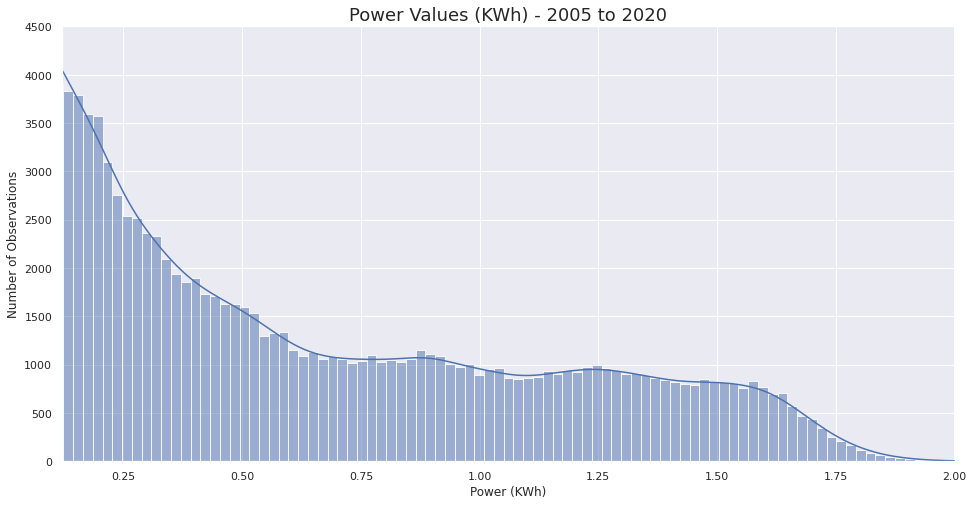

In [ ]:
plt.figure(figsize = (16,8))
ax = sns.histplot(data=df[df !=0], x='P', kde=True, bins= 100) #Ignoring the values that are equal to 0
ax.set_title("Power Values (KWh) - 2005 to 2020", fontsize=18)
ax.set(xlabel ="Power (KWh)", ylabel = "Number of Observations")
plt.ylim((0,4500))
plt.xlim((0.12, 2))
x_ticks = np.arange(0.1, 2.0, 0.25)
#plt.xticks(x_ticks, rotation=45)
#plt.ticklabel_format(style='plain', axis='x') 
ax = ax
plt.show


<Figure size 432x288 with 0 Axes>

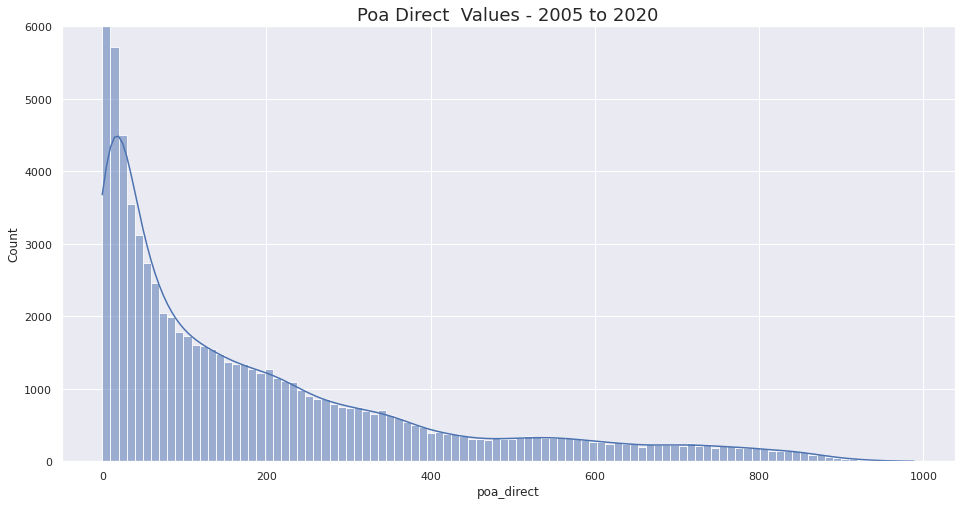

<Figure size 432x288 with 0 Axes>

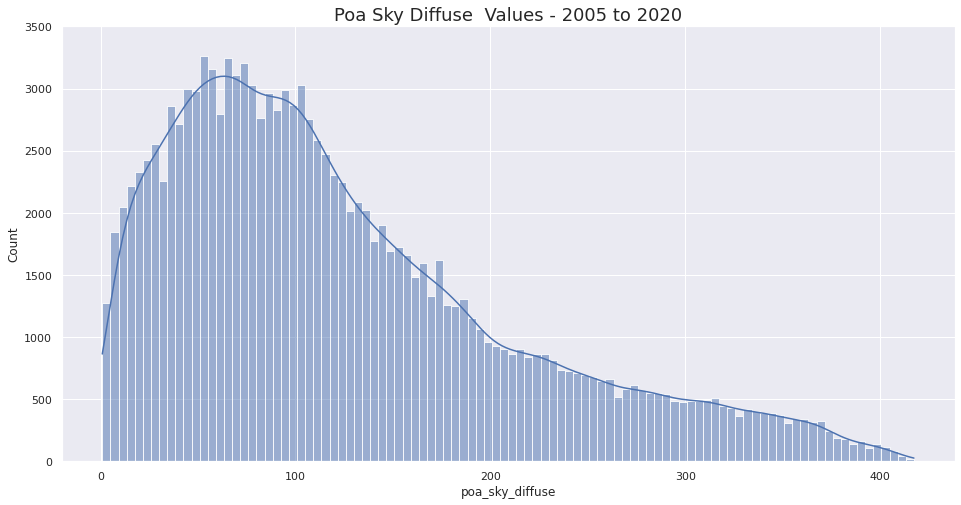

<Figure size 432x288 with 0 Axes>

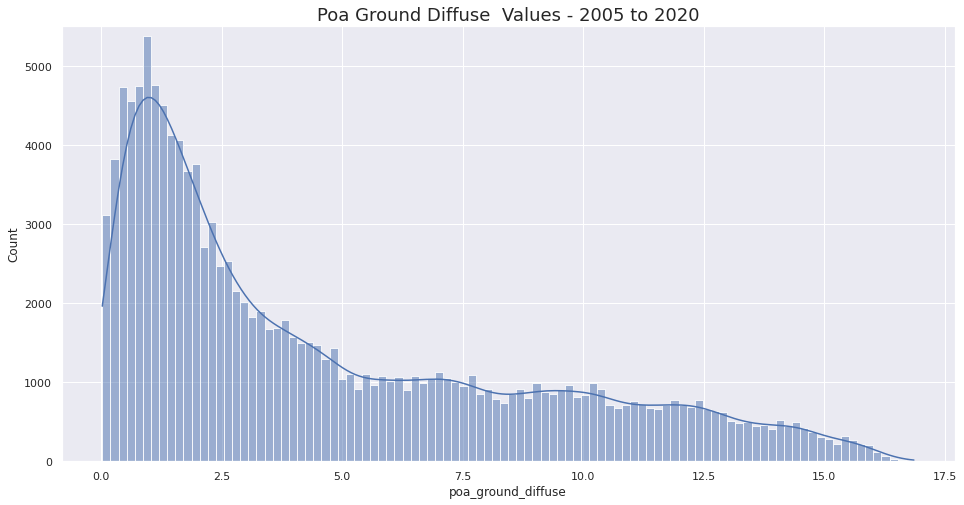

<Figure size 432x288 with 0 Axes>

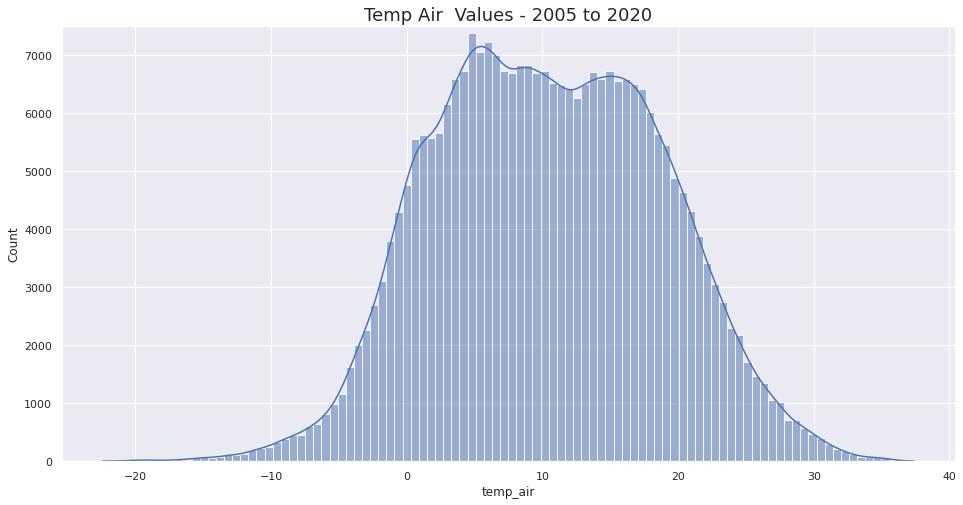

<Figure size 432x288 with 0 Axes>

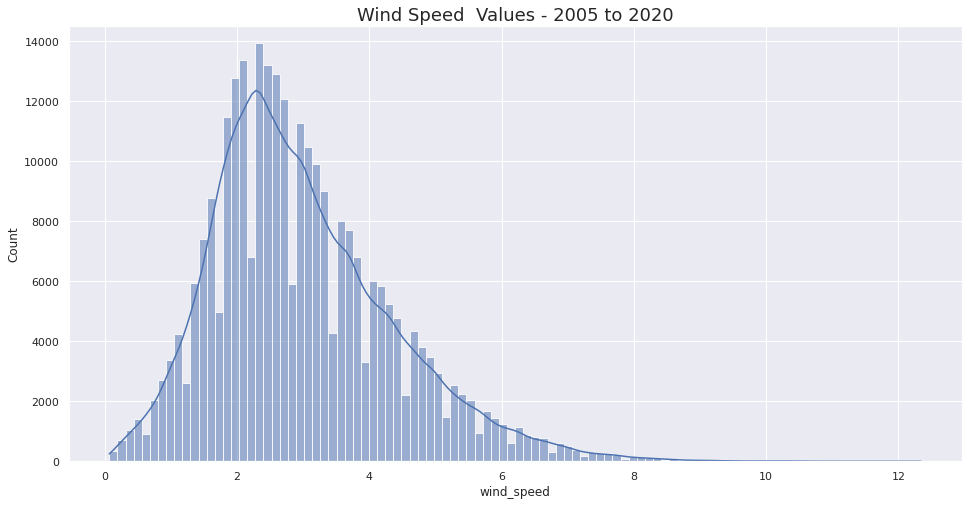

In [ ]:
column_plot =["poa_direct","poa_sky_diffuse", "poa_ground_diffuse","temp_air","wind_speed"]
for column in column_plot:
    plt.figure()
    plt.figure(figsize = (16,8))
    ax = sns.histplot(data=df[df !=0], x=column, kde=True, bins= 100) #Ignoring the values that are equal to 0
    splitcolumn = column.split("_")
    title = ""
    for name in splitcolumn:
        x_title = name.title()
        title += x_title + " " 
    ax.set_title(title + " Values - 2005 to 2020", fontsize=18)
    title = ""
    if column == "poa_direct":
        LowerLimit = 0
        UpperLimit = 6000
    elif column == "poa_sky_diffuse": 
        LowerLimit = 0
        UpperLimit = 3500
    elif column == "poa_ground_diffuse": 
        LowerLimit = 0
        UpperLimit = 5500
    elif column == "temp_air": 
        LowerLimit = 0
        UpperLimit = 7500
    elif column == "wind_speed": 
        LowerLimit = 0
        UpperLimit = 14500    
    plt.ylim((LowerLimit,UpperLimit))
    
    ax = ax
    plt.show